In [2]:
import pymde

import numpy as np
import matplotlib.pyplot as plt
import torch

In [92]:
# load the cooccurrence matrix from compressed npz file
# cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix.npz')['arr_0']
# cooccurrence_matrix.shape

cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix_wextra.npy')

In [93]:
import scipy.sparse as sp

# Build sparse matrix from the dense cooccurrence matrix, dropping the zero entries
cooccurrence_matrix_sparse = sp.csr_matrix(cooccurrence_matrix)
cooccurrence_graph = pymde.preprocess.Graph(cooccurrence_matrix_sparse)

In [94]:
dissimilarities = 1. / torch.log(cooccurrence_graph.weights + 1)

dissimilarity_graph = pymde.Graph.from_edges(cooccurrence_graph.edges, dissimilarities)
(dissimilarities.min(), dissimilarities.max())

(tensor(0.0512), tensor(4.4814))

In [95]:
shortest_path_graph = pymde.preprocess.graph.shortest_paths(dissimilarity_graph, verbose=True, n_workers=12)

May 01 05:54:17 AM: Computing shortest path distances (retaining 100.00 percent with max_distance=None) ...
May 01 05:54:18 AM: Graph is weighted ... using slow path.
May 01 05:54:56 AM: processed node 1/10097
May 01 05:56:56 AM: processed node 1010/10097
May 01 05:59:00 AM: processed node 2019/10097
May 01 06:01:07 AM: processed node 3028/10097
May 01 06:03:13 AM: processed node 4037/10097
May 01 06:05:21 AM: processed node 5046/10097
May 01 06:07:29 AM: processed node 6055/10097
May 01 06:09:37 AM: processed node 7064/10097
May 01 06:11:43 AM: processed node 8073/10097
May 01 06:13:48 AM: processed node 9082/10097
May 01 06:15:53 AM: processed node 10091/10097


In [114]:
n_neighbors = 50
embedding_dim = 3

mde = pymde.preserve_neighbors(shortest_path_graph, embedding_dim=embedding_dim, verbose=True, max_distance=10000, n_neighbors=n_neighbors)

May 01 08:01:44 AM: Computing 50-nearest neighbors, with max_distance=10000
May 01 08:01:50 AM: Computing quadratic initialization.


In [115]:
X = mde.embed(verbose=True,)

May 01 08:01:57 AM: Fitting a centered embedding into R^3, for a graph with 10097 items and 977999 edges.
May 01 08:01:57 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
May 01 08:01:58 AM: iteration 000 | distortion 0.530649 | residual norm 0.00892199 | step length 30.3 | percent change 0.155328
May 01 08:01:59 AM: iteration 030 | distortion 0.437619 | residual norm 0.00217142 | step length 1 | percent change 0.693966
May 01 08:02:01 AM: iteration 060 | distortion 0.431643 | residual norm 0.000662467 | step length 1 | percent change 0.392082
May 01 08:02:03 AM: iteration 090 | distortion 0.429592 | residual norm 0.000492182 | step length 0.523778 | percent change 0.941982
May 01 08:02:04 AM: iteration 120 | distortion 0.427734 | residual norm 0.000550746 | step length 1 | percent change 1.30282
May 01 08:02:06 AM: iteration 150 | distortion 0.425874 | residual norm 0.00042723 | step length 1 | percent change 0.827558
May 01 08:02:08 AM: iteration 180 | distort

/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:199: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "g+" (-> marker='+'). The keyword argument will take precedence.

/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:199: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g+" (-> color='g'). The keyword argument will take precedence.

/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:210: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "k+" (-> marker='+'). The keyword argument will take precedence.

/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:210: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.



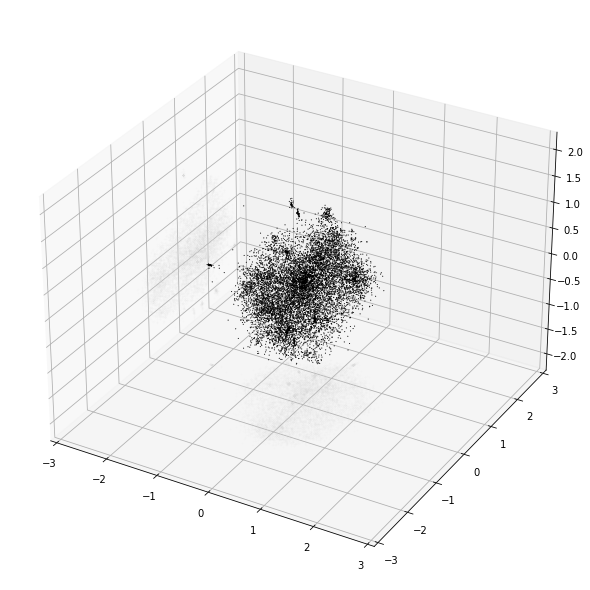

In [116]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [117]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(X), mde.embedding_dim))
    for i in range(len(X)):
        row = X[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_3d_50n.w2v'